In [ ]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [ ]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.9/693.9 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 67.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 18.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.8/722.8 kB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 63.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.6/273.6 kB 27.9 MB/s eta 

In [ ]:
# !pip install -U optuna==2.0.0

In [ ]:
EPOCHS = 500
INLEN = 32
HIDDEN = 64
LSTMLAYERS = 1
ATTHEADS = 1
DROPOUT = 0.1
BATCH = 32

N_FC = 36           # default forecast horizon
RAND = 1126           # set random state
N_SAMPLES = 100     # number of times a prediction is sampled from a probabilistic model
N_JOBS = -1          # parallel processors to use;  -1 = all processors

# default quantiles for QuantileRegression
QUANTILES = [0.01, 0.05, 0.1, 0.2, 0.25, 0.5, 0.75, 0.8, 0.9, 0.95, 0.99]

TRAIN = "19571201"  # train/test split
MSEAS = 60          # max seasonality to check: months
ALPHA = 0.05        # significance level for seasonality test
FIGSIZE = (9, 6)

qL1, qL2, qL3 = 0.01, 0.05, 0.10        # percentiles of predictions: lower bounds
qU1, qU2, qU3 = 1-qL1, 1-qL2, 1-qL3     # upper bounds derived from lower bounds
label_q1 = f'{int(qU1 * 100)} / {int(qL1 * 100)} percentile band'
label_q2 = f'{int(qU2 * 100)} / {int(qL2 * 100)} percentile band'
label_q3 = f'{int(qU3 * 100)} / {int(qL3 * 100)} percentile band'

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)


from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel, NaiveSeasonal, NaiveDrift, ExponentialSmoothing
from darts.utils.statistics import check_seasonality, extract_trend_and_seasonality
from darts.metrics import mape
from darts.datasets import AirPassengersDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from darts.utils.utils import ModelMode, SeasonalityMode, TrendMode


pd.set_option("display.precision",2)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.2f}'.format

In [ ]:
ts = AirPassengersDataset().load()
ts = ts / TimeSeries.from_series(ts.time_index.days_in_month)
ts.astype(np.float32)

df = ts.pd_dataframe()
df.head()

component,#Passengers
Month,
1949-01-01,3.61
1949-02-01,4.21
1949-03-01,4.26
1949-04-01,4.30
1949-05-01,3.90


In [ ]:
df.isnull().any()

component
#Passengers    False
dtype: bool

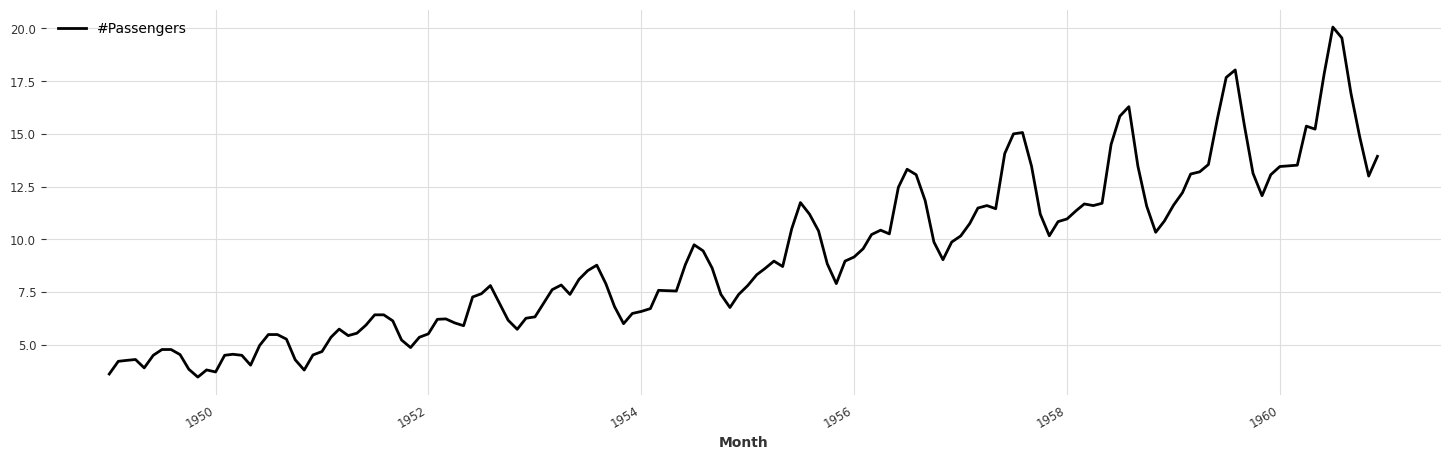

In [ ]:
plt.figure(100, figsize=(18, 5))
ts.plot()

plt.show()

In [ ]:
for i in range(2, MSEAS):
  r, mseas = check_seasonality(ts, m = i, max_lag = MSEAS, alpha = ALPHA)

  if r:
    print(mseas)

    break

12


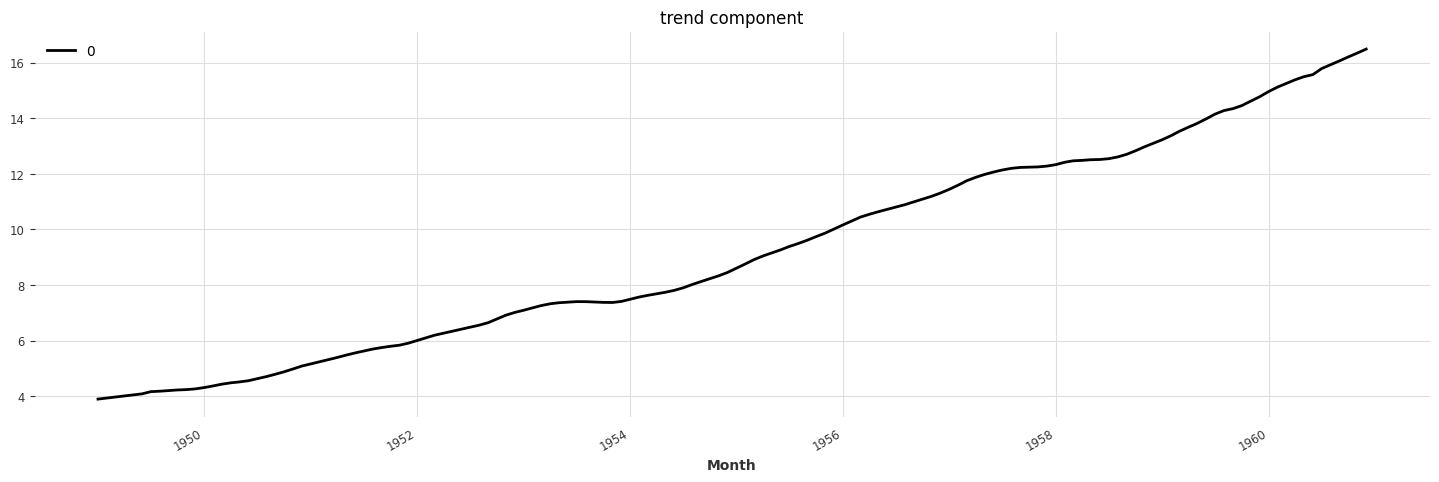

In [ ]:
trend, seasonal = extract_trend_and_seasonality(ts, freq = mseas)

plt.figure(100, figsize=(18, 5))
trend.plot()
plt.title("trend component")

plt.show()

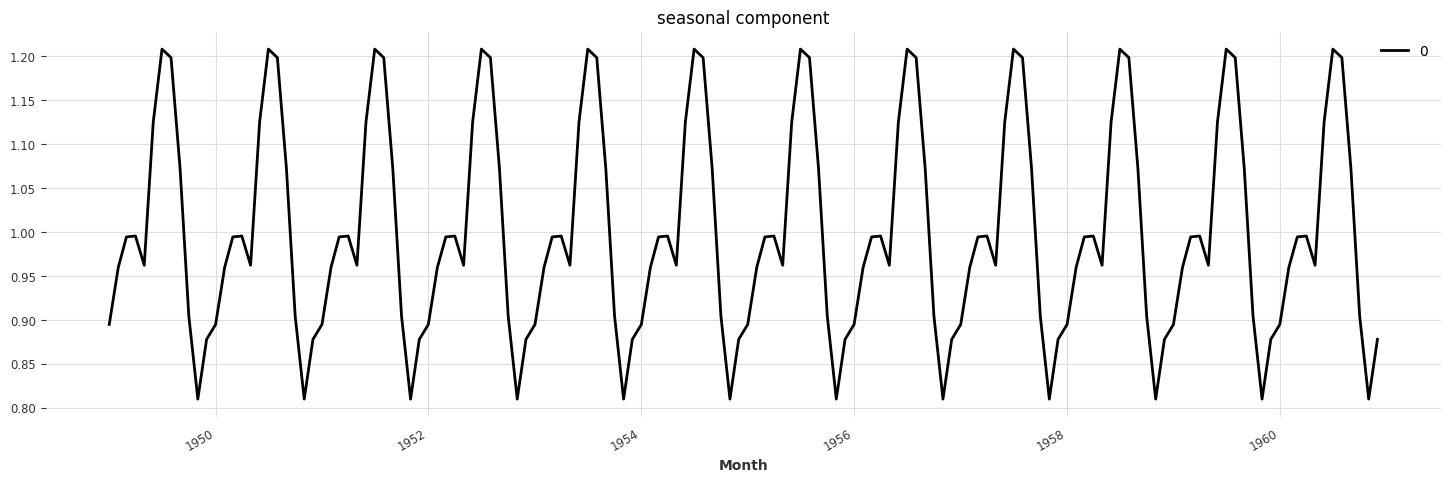

In [ ]:
plt.figure(100, figsize=(18, 5))
seasonal.plot()
plt.title("seasonal component")

plt.show()

In [ ]:
split = pd.Timestamp(TRAIN)
ts_train, ts_test = ts.split_after(split)

scaler = Scaler()
scaled_train = scaler.fit_transform(ts_train)
scaled_test = scaler.transform(ts_test)

In [ ]:
scaled_ts = scaler.transform(ts)

In [ ]:
cov = datetime_attribute_timeseries(ts, attribute = "year", one_hot = False)
cov = cov.stack(datetime_attribute_timeseries(ts, attribute = "month", one_hot = False))
cov = cov.stack(TimeSeries.from_times_and_values(times = ts.time_index, values = np.arange(len(ts)), columns = ["linear_increase"]))
cov = cov.astype(np.float32)

train_cov, test_cov = cov.split_after(split)

cov_scaler = Scaler()
scaled_train_cov = cov_scaler.fit_transform(train_cov)
scaled_cov = cov_scaler.transform(cov)

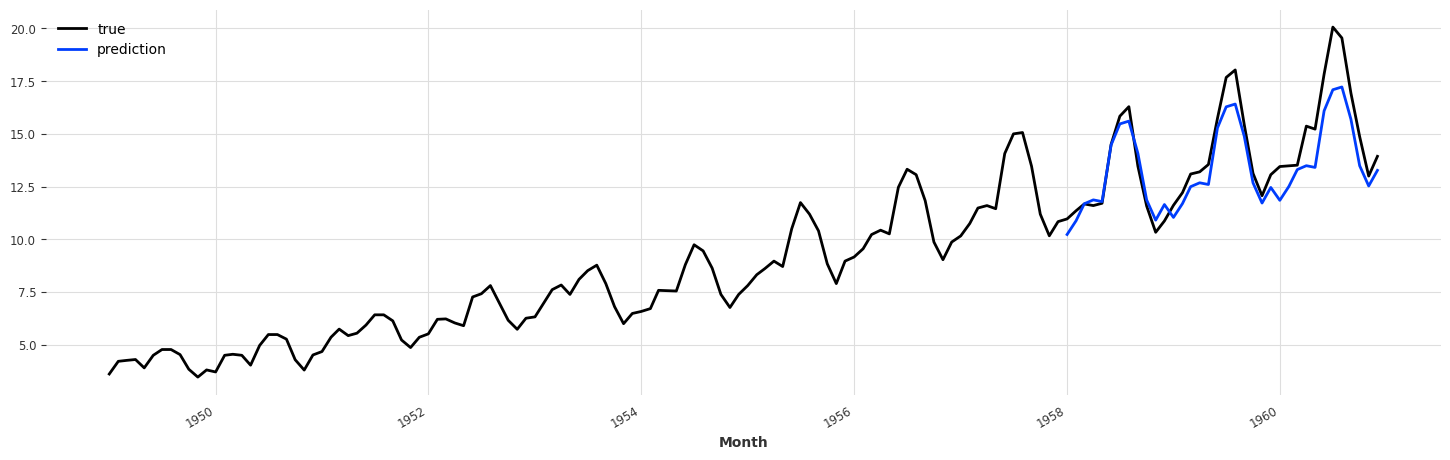

In [ ]:
naive_seasonal = NaiveSeasonal(K = mseas)
naive_seasonal.fit(ts_train)
y_pred1 = naive_seasonal.predict(len(ts_test))

naive_drift = NaiveDrift()
naive_drift.fit(ts_train)
y_pred2 = naive_drift.predict(len(ts_test))

y_pred = y_pred1 + y_pred2 - ts_train.last_value()

plt.figure(100, figsize=(18, 5))
ts.plot(label = "true")
y_pred.plot(label = "prediction")
plt.legend()

plt.show()

In [ ]:
print(mape(ts_test, y_pred))

5.711689250932598


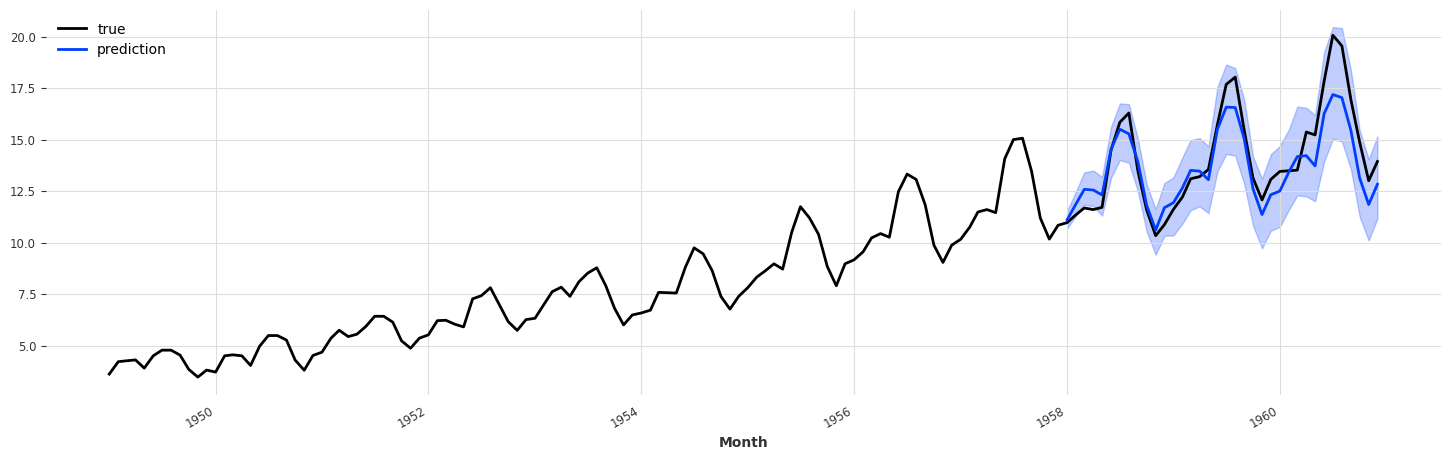

In [ ]:
exp_smothing = ExponentialSmoothing(seasonal_periods = mseas, seasonal = ModelMode.MULTIPLICATIVE)
exp_smothing.fit(ts_train)
y_pred = exp_smothing.predict(len(ts_test), num_samples = N_SAMPLES)

plt.figure(100, figsize=(18, 5))
ts.plot(label = "true")
y_pred.plot(label = "prediction")
plt.legend()

plt.show()

In [ ]:
print(mape(ts_test, y_pred))

5.6546321738897625


In [ ]:
import torch

if torch.cuda.is_available():
  pl_trainer_kwargs = {
    "accelerator": "gpu",
    "devices": [0]
  }

In [ ]:
tft = TFTModel(input_chunk_length = INLEN, output_chunk_length = N_FC, hidden_size = HIDDEN, lstm_layers = LSTMLAYERS,
        num_attention_heads = ATTHEADS, dropout = DROPOUT, batch_size = BATCH, n_epochs = EPOCHS, pl_trainer_kwargs = pl_trainer_kwargs,
        random_state = 1126, force_reset = True, likelihood = QuantileRegression(quantiles = QUANTILES))
tft.fit(scaled_train, future_covariates = scaled_cov, verbose = True)

Training: 0it [00:00, ?it/s]

TFTModel(hidden_size=64, lstm_layers=1, num_attention_heads=1, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=<darts.utils.likelihood_models.QuantileRegression object at 0x7d83ed7da5f0>, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=32, output_chunk_length=36, batch_size=32, n_epochs=500, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': [0]}, random_state=1126, force_reset=True)

In [ ]:
y_pred = tft.predict(n = len(ts_test), num_samples = N_SAMPLES, n_jobs = N_JOBS)
y_pred = scaler.inverse_transform(y_pred)

Predicting: 0it [00:00, ?it/s]

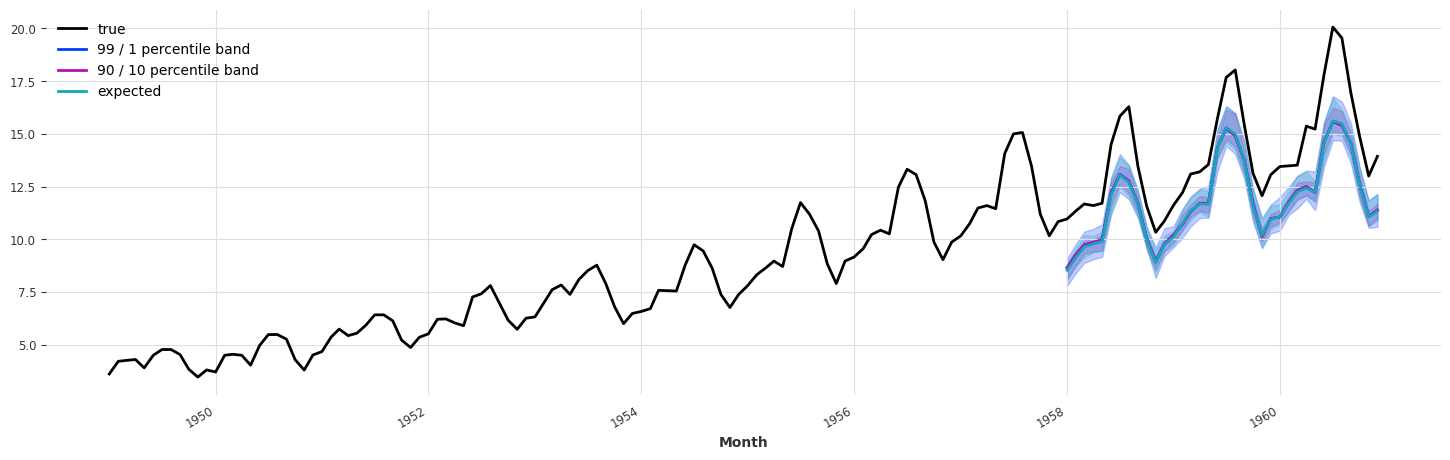

In [ ]:
plt.figure(100, figsize=(18, 5))
ts.plot(label = "true")
y_pred.plot(low_quantile=qL1, high_quantile=qU1, label=label_q1)    # plot U1 quantile band
#ts_pred.plot(low_quantile=qL2, high_quantile=qU2, label=label_q2)   # plot U2 quantile band
y_pred.plot(low_quantile=qL3, high_quantile=qU3, label=label_q3)    # plot U3 quantile band
y_pred.plot(central_quantile="mean", label="expected")
plt.legend()

plt.show()

In [ ]:
print(mape(ts_test, y_pred))

15.26324433214258
